# Preliminaries: Inspect and Set up environment

In [1]:
# Import all libraries required

# Data Processing and EDA
import datetime
import pandas as pd
import numpy as np

# For bioinformatics tasks
from Bio import SeqIO
# older alignment method
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
# newer alignment method - not using this, 
# but just don't want to forget this option
from Bio import Align
from Bio.Align import PairwiseAligner
import multiprocessing

# For Machine Learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# For Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from seaborn import heatmap
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

/home/ajvilleg/miniforge3/envs/learn-flu/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
# Environment
# Show all the output for every print not just the last
from IPython.core.interactiveshell import InteractiveShell
# Configuration and settings
InteractiveShell.ast_node_interactivity = "all"
# To check if in Google Colab
from IPython.core.getipython import get_ipython
# To display all the output in a nicer table
from IPython.display import display
# To time the execution of the code
import time
import os.path

In [3]:
print(datetime.datetime.now())

2024-08-20 00:50:55.245068


In [4]:
!which python

/home/ajvilleg/miniforge3/envs/learn-flu/bin/python


In [5]:
!python --version

Python 3.12.2


In [6]:
!echo $PYTHONPATH

In [7]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
#if 'google.colab' in str(get_ipython()):
    # TODO: if running on Google Colab, install any packages you need to here. For example:
    #!pip install unidecode
    #!pip install category_encoders
    #!pip install scikeras

In [9]:
# Let's minimize randomness
# numpy
np.random.seed(42)

Start the timer

In [10]:
# Start timer
start_time = time.time()

In [11]:
import joblib  # For saving and loading models

In [12]:
def check_duplicate_headers(records):
    """Checks for duplicate FASTA headers in a list of SeqIO records.

    Args:
        records: A list of SeqRecord objects.

    Returns:
        list: A list of indices corresponding to duplicate records.
        list: A list of duplicate headers.
    """
    seen = set()
    duplicates = []
    duplicate_headers = []
    for i, record in enumerate(records):
        header = record.description  # Or use record.id
        if header in seen:
            duplicates.append(i)
            duplicate_headers.append(header)
        else:
            seen.add(header)
    return duplicates, duplicate_headers

In [13]:
def get_sequence_length(row, column):
    """Calculates the length of the sequence in the specified column."""
    return len(row[column])

In [14]:
# Define k-mer length
# kmer_length = 12
kmer_length = 6

In [15]:
# Function to extract kmers (can be reused)
def get_kmers(sequence, k):
  """
  Extracts all k-mers (subsequences of length k) from a DNA sequence.
  """
  kmers = []
  for i in range(len(sequence) - k + 1):
    kmer = sequence[i:i+k]
    kmers.append(kmer)
  return kmers

In [16]:
# Define chunk size (adjust as needed)
chunk_size = 100

In [17]:
def process_chunk(chunk_dict):
    """
    Processes a chunk of data from the kmer_dict and returns one-hot encoded features.
    """
    chunk_ha_features = []

    # Get unique k-mers across all sequences in the chunk
    # Only run this code if 'ohe' attribute does not exist. This is to ensure that the one-hot encoder is only fit once.
    # So, for the test data, 'ohe' already defined, this code will not run (will not do a fit on a new OHE) and go directly to the transformation step below
    if not hasattr(process_chunk, 'ohe'):
        all_kmers = set()
        for kmer_dict_row in chunk_dict.values():
            ha_kmers = kmer_dict_row["HA"]
            all_kmers.update(ha_kmers)

        # Create one-hot encoder (only fit on the first chunk for consistent categories)
        process_chunk.ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        process_chunk.ohe.fit([[kmer] for kmer in list(all_kmers)])  # Fit on unique kmers

    # Transform each sequence into a one-hot encoded vector
    for kmer_dict_row in chunk_dict.values():
        ha_kmers = kmer_dict_row["HA"]
        kmer_indices = process_chunk.ohe.transform([[kmer] for kmer in ha_kmers]).sum(axis=0)
        chunk_ha_features.append(kmer_indices)

    return chunk_ha_features

In [18]:
def format_runtime(total_time):
    """
    Formats a given runtime (in seconds) into a human-readable string, 
    omitting zero-value components (days, hours, minutes).

    Args:
        total_time (float): The total runtime in seconds.

    Returns:
        str: A formatted string representing the runtime.
    """
    
    # Convert total time in seconds to a timedelta object
    td = datetime.timedelta(seconds=total_time)\
    
    # Extract days, hours, minutes, and seconds from the timedelta
    days = td.days
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Create a list to store non-zero time components and their labels
    time_components = []
    if days > 0:
        time_components.append(f"{days} days")
    if hours > 0:
        time_components.append(f"{hours} hours")
    if minutes > 0:
        time_components.append(f"{minutes} minutes")
    time_components.append(f"{seconds:.2f} seconds")  # Always include seconds

    # Join the time components with commas and "and"
    formatted_time = ", ".join(time_components[:-1])  # Join all but the last
    if len(time_components) > 1:
        formatted_time += " and " + time_components[-1]  # Add "and" and the last
    else:
        formatted_time = time_components[0]  # If only one component, use it directly

    return formatted_time

# Load the Model, LabelEncoder, and One-Hot Encoder

In [19]:
# Load the model, LabelEncoder, OHE
model_filename = "model_learn-flu-train_2024-08-20_00:25:13.joblib" # Update the filename of the trained model as required
model_data = joblib.load(model_filename)
model = model_data['model']
le = model_data['label_encoder']
process_chunk.ohe = model_data['one_hot_encoder'] 

# 5.0 Test

## 5.1 Load and Prepare Unseen Test Data

In [20]:
# Parse the FASTA file for the new dataset
test_records = list(SeqIO.parse("/home/ajvilleg/Netdrive/AI/GISAID/EpiFlu_Test/11-Aug-2024_Oceania/gisaid_epiflu_sequence_11-Aug-2024.fasta", "fasta"))

In [21]:
# Check for duplicates before extracting details
duplicate_indices, duplicate_headers = check_duplicate_headers(test_records)
if duplicate_indices:
    print("Warning: Found the following duplicate FASTA headers:")
    for header in duplicate_headers:
        print(header)
    print("One copy of each duplicate record will be kept.")

    # Create a set of unique indices to keep
    indices_to_keep = set(range(len(test_records))) - set(duplicate_indices)

    # Filter the records list
    test_records = [record for i, record in enumerate(test_records) if i in indices_to_keep]
    print("Duplicate records have been removed, keeping one copy of each.")

A/duck/Australia/341/1983|EPI_ISL_627|A_/_H15N8||NA|1983-01-01|
A/duck/Australia/341/1983|EPI_ISL_627|A_/_H15N8||HA|1983-01-01|
A/duck/Australia/341/1983|EPI_ISL_627|A_/_H15N8||HA|1983-01-01|
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|HA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|HA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|HA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|HA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|HA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|HA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|HA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|NA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|HA|1999-01-01|unassigned
A/New_Caledonia/20/1999|EPI_ISL_649|A_/_H1N1|seasonal|NA|1999-01-01|unassigned
A/duck/Australia/7

In [22]:
# Extract the details from the description of each record
test_data = []

# Iterate through records for every pair for NA and HA segments
for record1, record2 in zip(test_records[::2], test_records[1::2]):
    description1 = record1.description.split('|')
    description2 = record2.description.split('|')

    # Assume the isolate name is the same for both segments
    isolate_name1 = description1[0].strip()
    isolate_name2 = description2[0].strip()
    if isolate_name1 != isolate_name2:
        print(f"Isolate names do not match: {isolate_name1} vs {isolate_name2}")
        raise ValueError("Isolate names do not match")

    # Assume the isolate ID is the same for both segments
    isolate_id1 = description1[1].strip()
    isolate_id2 = description2[1].strip()
    if isolate_id1 != isolate_id2:
        print(f"Isolate IDs do not match: {isolate_id1} vs {isolate_id2}")
        raise ValueError("Isolate IDs do not match")

    # Assume the flu type is the same for both segments
    flu_type1 = description1[2].strip()
    flu_type2 = description2[2].strip()
    if flu_type1 != flu_type2:
        print(f"Flu types do not match: {flu_type1} vs {flu_type2}")
        raise ValueError("Flu types do not match")

    # Assume the lineage is the same for both segments
    lineage1 = description1[3].strip()
    lineage2 = description2[3].strip()
    if lineage1 != lineage2:
        print(f"Lineages do not match: {lineage1} vs {lineage2}")
        raise ValueError("Lineages do not match")

    # The segment labels are different for NA and HA segments
    segment1 = description1[4].strip()
    segment2 = description2[4].strip()  

    # Assume the collection date is the same for both segments
    collection_date1 = description1[5].strip()
    collection_date2 = description2[5].strip()
    if collection_date1 != collection_date2:
        print(f"Collection dates do not match: {collection_date1} vs {collection_date2}")
        raise ValueError("Collection dates do not match")

    # Assume the clade is the same for both segments. This is important as this will be our label for classification
    clade1 = description1[6].strip()
    clade2 = description2[6].strip()
    if clade1 != clade2:
        print(f"Clades do not match: {clade1} vs {clade2}")
        raise ValueError("Clades do not match")

    # The sequences will be different corresopnding to the NA and HA segments
    sequence1 = str(record1.seq)
    sequence2 = str(record2.seq)
    if segment1 == 'HA':
        sequence_ha = sequence1
        sequence_na = sequence2
    else: # segment2 == 'HA'
        sequence_ha = sequence2
        sequence_na = sequence1
    test_data.append([isolate_name1, isolate_id1, flu_type1, lineage1, sequence_ha, sequence_na, collection_date1, clade1])

test_df = pd.DataFrame(test_data, columns=['Isolate_Name', 'Isolate_ID', 'Flu_Type', 'Lineage', 'HA', 'NA', 'Collection Date', 'Clade'])


In [23]:
# Take a look at the data
display(test_df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade
0,A/Victoria/5287/2022,EPI_ISL_16613629,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2022-12-23,6B.1A.5a.2a.1
1,A/South_Australia/21/2015,EPI_ISL_196611,A_/_H3N2,,atgaagactatcattgctttgagctacattctatgtctggtttccg...,atgaatccaaatcaaaagataataacgattggctctgtttctctca...,2015-03-13,3C.2
2,A/Victoria/5235/2022,EPI_ISL_16613628,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2022-12-20,6B.1A.5a.2a
3,A/Victoria/5215/2022,EPI_ISL_16613631,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2022-12-03,6B.1A.5a.2a.1
4,A/Victoria/5246/2022,EPI_ISL_16613630,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2022-12-31,6B.1A.5a.2a
...,...,...,...,...,...,...,...,...
15509,A/New_Zealand/3570/2022,EPI_ISL_16383775,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagcaacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2022-07-10,3C.2a1b.2a.2a.1
15510,A/New_Zealand/3629/2022,EPI_ISL_16383774,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagcaacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2022-07-16,3C.2a1b.2a.2a.1
15511,A/New_Zealand/3562/2022,EPI_ISL_16383767,A_/_H3N2,,ggataatcctattaaccatgaagactatcattgctttgagcaacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2022-07-19,3C.2a1b.2a.2a
15512,A/New_Zealand/3581/2022,EPI_ISL_16383766,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagcaacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2022-07-12,3C.2a1b.2a.2a.1


In [24]:
# Extract Type using regular expressions
test_df['Type'] = test_df['Flu_Type'].astype(str).str.extract(r'(A|B|C)').fillna('')

In [25]:
# Extract H_Subtype and N_Subtype with updated regex, allowing for one or more digits after H or N.
test_df['H_Subtype'] = test_df['Flu_Type'].astype(str).str.extract(r'(H\d+)').fillna('')
test_df['N_Subtype'] = test_df['Flu_Type'].astype(str).str.extract(r'(N\d+)').fillna('')
print(test_df['H_Subtype'].value_counts().to_markdown(numalign="left", stralign="left"))
print(test_df['N_Subtype'].value_counts().to_markdown(numalign="left", stralign="left"))

| H_Subtype   | count   |
|:------------|:--------|
| H3          | 9505    |
| H1          | 5667    |
| H6          | 47      |
| H4          | 47      |
| H10         | 43      |
| H7          | 42      |
| H5          | 31      |
| H2          | 30      |
| H11         | 29      |
| H12         | 21      |
|             | 20      |
| H9          | 17      |
| H8          | 7       |
| H15         | 6       |
| H13         | 1       |
| H16         | 1       |
| N_Subtype   | count   |
|:------------|:--------|
| N2          | 9554    |
| N1          | 5679    |
| N8          | 71      |
| N7          | 44      |
| N9          | 37      |
| N3          | 35      |
| N5          | 33      |
| N6          | 28      |
|             | 20      |
| N4          | 13      |


In [26]:
# Take a look at the data again
display(test_df)

,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade,Type,H_Subtype,N_Subtype
0,A/Victoria/5287/2022,EPI_ISL_16613629,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2022-12-23,6B.1A.5a.2a.1,A,H1,N1
1,A/South_Australia/21/2015,EPI_ISL_196611,A_/_H3N2,,atgaagactatcattgctttgagctacattctatgtctggtttccg...,atgaatccaaatcaaaagataataacgattggctctgtttctctca...,2015-03-13,3C.2,A,H3,N2
2,A/Victoria/5235/2022,EPI_ISL_16613628,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2022-12-20,6B.1A.5a.2a,A,H1,N1
3,A/Victoria/5215/2022,EPI_ISL_16613631,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2022-12-03,6B.1A.5a.2a.1,A,H1,N1
4,A/Victoria/5246/2022,EPI_ISL_16613630,A_/_H1N1,pdm09,atgaaggcaatactagtagttatgctgtatacatttacaaccgcaa...,atgaatccaaaccaaaagataataaccattggttctatttgtatga...,2022-12-31,6B.1A.5a.2a,A,H1,N1
...,...,...,...,...,...,...,...,...,...,...,...
15509,A/New_Zealand/3570/2022,EPI_ISL_16383775,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagcaacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2022-07-10,3C.2a1b.2a.2a.1,A,H3,N2
15510,A/New_Zealand/3629/2022,EPI_ISL_16383774,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagcaacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2022-07-16,3C.2a1b.2a.2a.1,A,H3,N2
15511,A/New_Zealand/3562/2022,EPI_ISL_16383767,A_/_H3N2,,ggataatcctattaaccatgaagactatcattgctttgagcaacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2022-07-19,3C.2a1b.2a.2a,A,H3,N2
15512,A/New_Zealand/3581/2022,EPI_ISL_16383766,A_/_H3N2,,ggataattctattaaccatgaagactatcattgctttgagcaacat...,agtaaagatgaatccaaatcaaaagataataacgattggctctgtt...,2022-07-12,3C.2a1b.2a.2a.1,A,H3,N2


## 5.2 EDA

### 5.2.1 Dataframe structure

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15514 entries, 0 to 15513
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Isolate_Name     15514 non-null  object
 1   Isolate_ID       15514 non-null  object
 2   Flu_Type         15514 non-null  object
 3   Lineage          15514 non-null  object
 4   HA               15514 non-null  object
 5   NA               15514 non-null  object
 6   Collection Date  15514 non-null  object
 7   Clade            15514 non-null  object
 8   Type             15514 non-null  object
 9   H_Subtype        15514 non-null  object
 10  N_Subtype        15514 non-null  object
dtypes: object(11)
memory usage: 1.3+ MB


In [28]:
# Convert all columns to strings except Collection Date
test_df = test_df.astype(str)

# Convert "Collection Date" column to date
test_df["Collection Date"] = pd.to_datetime(test_df["Collection Date"])

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15514 entries, 0 to 15513
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Isolate_Name     15514 non-null  object        
 1   Isolate_ID       15514 non-null  object        
 2   Flu_Type         15514 non-null  object        
 3   Lineage          15514 non-null  object        
 4   HA               15514 non-null  object        
 5   NA               15514 non-null  object        
 6   Collection Date  15514 non-null  datetime64[ns]
 7   Clade            15514 non-null  object        
 8   Type             15514 non-null  object        
 9   H_Subtype        15514 non-null  object        
 10  N_Subtype        15514 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 1.3+ MB


### 5.2.2 Describe

In [29]:
test_df.describe()

,Collection Date
count,15514
mean,2018-05-17 02:48:28.031455488
min,1934-12-31 00:00:00
25%,2016-09-20 00:00:00
50%,2019-04-02 00:00:00
75%,2023-01-12 00:00:00
max,2024-07-21 00:00:00


### 5.2.3 Duplicated rows

In [30]:
# Check for duplicated rows in test data
print(f'test_df has {test_df.duplicated().sum()} duplicate rows')
display(test_df[test_df.duplicated()])
# Drop duplicates and check again
test_df.drop_duplicates(inplace=True)
print(f'test_df has {test_df.duplicated().sum()} duplicate rows')

test_df has 0 duplicate rows


,Isolate_Name,Isolate_ID,Flu_Type,Lineage,HA,NA,Collection Date,Clade,Type,H_Subtype,N_Subtype


test_df has 0 duplicate rows


### 5.2.4 Missing values / NaN / Empty Strings

In [31]:
# Check for missing values and empty strings
print("NaN values in test_df:")
print(test_df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in test_df:")
for col in test_df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(test_df[col] == '').sum()}")     # Count empty strings

NaN values in test_df:
Isolate_Name       0
Isolate_ID         0
Flu_Type           0
Lineage            0
HA                 0
NA                 0
Collection Date    0
Clade              0
Type               0
H_Subtype          0
N_Subtype          0
dtype: int64

Empty string values in test_df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 9867
HA: 0
NA: 0
Clade: 301
Type: 0
H_Subtype: 20
N_Subtype: 20


In [32]:
# Drop rows with nulls or empty strings in Clade, ignore Lineage nulls/empty strings
test_df.replace('', pd.NA, inplace=True)  # Replace empty strings with NaN
test_df.dropna(subset=['Clade'], inplace=True)  # Drop rows where Clade is NaN

In [33]:
# Check for missing values and empty strings
print("NaN values in test_df:")
print(test_df.isnull().sum())  # Check for NaN values
print("\nEmpty string values in test_df:")
for col in test_df.select_dtypes(include=['object']):  # Iterate over columns with string datatype
    print(f"{col}: {(test_df[col] == '').sum()}")     # Count empty strings

NaN values in test_df:
Isolate_Name          0
Isolate_ID            0
Flu_Type              0
Lineage            9566
HA                    0
NA                    0
Collection Date       0
Clade                 0
Type                  0
H_Subtype            11
N_Subtype            11
dtype: int64

Empty string values in test_df:
Isolate_Name: 0
Isolate_ID: 0
Flu_Type: 0
Lineage: 0
HA: 0
NA: 0
Clade: 0
Type: 0
H_Subtype: 0
N_Subtype: 0


### 5.2.5 Class Imbalance

#### Clade Imbalance

In [34]:
test_df['Clade'].value_counts()

Clade
6B.1A.5a.2a           2644
3C.2                  1775
3C.2a1b.2a.2a.3a.1    1522
3C.3a                 1098
3C.2a1b.2a.2a.1       1067
3C.2a1b.2b             882
6B.1                   867
3C.2a2                 542
3C.2a1                 530
3C.2a1b.1              527
6B.1A.5a               417
6B.1A.5a.2a.1          408
3C.2a3                 315
6B.1A.6                278
3C.2a1b.2              267
6B.1A                  202
6B.1A.5a.1             200
3C.2a                  185
unassigned             180
6B.1A.2                152
3C.2a1b.2a.2a.3        128
6B.1A.5a.2             128
3C.3a1                 127
6B.1A.5b               116
3C.2a1b.2a.2a          105
6B.1A.1                 90
3C.2a1b.2a.1            74
3C.2a1b.2a.2b           65
3C.2a1b.1b              47
3C.2a1b.2a.2a.1b        47
6B.2                    45
3C.2a1b.2a.2a.1a        32
EA_nonGsGD              29
3C.2a1b.2a              21
3C.2a1b.2a.2a.3a        20
3C.2a4                  17
3C.2a1b.1a            

In [35]:
# Drop rows with "unassigned" in 'Clade' from the training data
test_df = test_df[test_df['Clade'] != 'unassigned']  # Filter out rows with label "unassigned"

#### HACK: Drop rows in 'Clade' from the test data, as it is not present in the training data 
May not be necessary anymore due to OSR

In [36]:
# # Temporary HACK: Drop rows with "2.3.2.1c" in 'Clade' from the test data (TODO: which test data?), 
# # as it is not present in the training data 
# test_df = test_df[test_df['Clade'] != '2.3.2.1c']  # Filter out rows with label "2.3.2.1c"


In [37]:
# # Temporary HACK: Drop rows with "Am_nonGsGD" in 'Clade' from the test data (TODO: which test data?), 
# # as it is not present in the training data 
# test_df = test_df[test_df['Clade'] != 'Am_nonGsGD']  # Filter out rows with label "Am_nonGsGD"

In [38]:
# # Temporary HACK: Drop rows with "3C.2a1b.2a.1a.1" in 'Clade' from the test data (EpiFlu_Test/11-Aug-2024_Oceania/gisaid_epiflu_sequence_11-Aug-2024.fasta), 
# # as it is not present in the training data (EpiFlu_Training/01-Aug-2024/gisaid_epiflu_sequence_01-Aug-2024_All_Hosts_Type_A_USA.fasta) 
# test_df = test_df[test_df['Clade'] != '3C.2a1b.2a.1a.1']  # Filter out rows with label "3C.2a1b.2a.1a.1"

In [39]:
# # Temporary HACK: Drop rows with "2.3.2.1a" in 'Clade' from the test data (EpiFlu_Test/11-Aug-2024_Oceania/gisaid_epiflu_sequence_11-Aug-2024.fasta), 
# # as it is not present in the training data (EpiFlu_Training/01-Aug-2024/gisaid_epiflu_sequence_01-Aug-2024_All_Hosts_Type_A_USA.fasta) 
# test_df = test_df[test_df['Clade'] != '2.3.2.1a']  # Filter out rows with label "2.3.2.1a"

In [40]:
test_df['Clade'].value_counts()

Clade
6B.1A.5a.2a           2644
3C.2                  1775
3C.2a1b.2a.2a.3a.1    1522
3C.3a                 1098
3C.2a1b.2a.2a.1       1067
3C.2a1b.2b             882
6B.1                   867
3C.2a2                 542
3C.2a1                 530
3C.2a1b.1              527
6B.1A.5a               417
6B.1A.5a.2a.1          408
3C.2a3                 315
6B.1A.6                278
3C.2a1b.2              267
6B.1A                  202
6B.1A.5a.1             200
3C.2a                  185
6B.1A.2                152
3C.2a1b.2a.2a.3        128
6B.1A.5a.2             128
3C.3a1                 127
6B.1A.5b               116
3C.2a1b.2a.2a          105
6B.1A.1                 90
3C.2a1b.2a.1            74
3C.2a1b.2a.2b           65
3C.2a1b.1b              47
3C.2a1b.2a.2a.1b        47
6B.2                    45
3C.2a1b.2a.2a.1a        32
EA_nonGsGD              29
3C.2a1b.2a              21
3C.2a1b.2a.2a.3a        20
3C.2a4                  17
3C.2a1b.1a              16
6B.1A.7               

#### H_Subtype Imbalance

In [41]:
test_df['H_Subtype'].value_counts()

H_Subtype
H3    9434
H1    5564
H5      30
Name: count, dtype: int64

#### N_Subtype Imbalance

In [42]:
test_df['N_Subtype'].value_counts()

N_Subtype
N2    9441
N1    5568
N3      15
N7       2
N9       2
Name: count, dtype: int64

### 5.2.6 Shape

In [43]:
test_df.shape

(15033, 11)

### 5.2.7 Look at sequence length stats

In [44]:
new_ha_sequence_lengths = test_df.apply(get_sequence_length, axis=1, column="HA")
new_na_sequence_lengths = test_df.apply(get_sequence_length, axis=1, column="NA")
print("Sequence lengths in HA columns:")
new_ha_sequence_lengths.describe()
print("Sequence lengths in NA columns:")
new_na_sequence_lengths.describe()

Sequence lengths in HA columns:


count    15033.000000
mean      1719.698397
std         18.534440
min       1674.000000
25%       1701.000000
50%       1721.000000
75%       1737.000000
max       1794.000000
dtype: float64

Sequence lengths in NA columns:


count    15033.000000
mean      1420.847469
std         20.857609
min       1350.000000
25%       1410.000000
50%       1410.000000
75%       1433.000000
max       3152.000000
dtype: float64

## 5.3 K-mers and k-mer encoding

In [45]:
# Create an empty dictionary to store kmers for each sequence in the new dataset (identified by row index)
test_kmer_dict = {}

In [46]:
# Extract k-mers from each sequence and store them in the dictionary
for i, row in test_df.iterrows():
    # Extract kmers from HA sequence (assuming it exists)
    ha_kmers = []
    if "HA" in row:  # Check if "HA" column exists
        sequence = str(row["HA"])
        ha_kmers = get_kmers(sequence, kmer_length)

    # Store kmers separately in the dictionary
    test_kmer_dict[i] = {
        "HA": ha_kmers
    }

### 5.3.1 One-Hot Encoding using chunking to optimize memory usage

In [47]:
# One-Hot Encoding on new data using the same kmer chunking logic as before to optimize memory usage
# Apply the same k-mer extraction and chunking as with training data
test_ha_features = []
for i in range(0, len(test_kmer_dict), chunk_size):
    # Get a chunk of data
    chunk_dict = dict(list(test_kmer_dict.items())[i:i + chunk_size])
    
    # Process features for the chunk
    chunk_ha_features = process_chunk(chunk_dict)
    
    # Append features from the chunk
    test_ha_features.extend(chunk_ha_features)

## 5.4 Prediction

In [48]:
# OHE
# Convert list of lists to numpy array
X_new = np.array(test_ha_features)  

In [49]:
# # Predict using the trained model
# y_pred_new = model.predict(X_new)

# # Decode predictions to get the original Clade labels
# predicted_clades = le.inverse_transform(y_pred_new)

# # Add predicted clades back to new_df
# test_df['Predicted_Clade'] = predicted_clades

# # Display the data with predictions and true clades
# display(test_df[['Isolate_Name', 'Isolate_ID', 'Collection Date', 'Clade', 'Predicted_Clade']])  # Display true and predicted clades

In [50]:
# Predict probabilities on new data, using the trained model, and employ Open-Set Recognition (OSR)
y_pred_proba_new = model.predict_proba(X_new)

# Calculate confidence scores
confidence_scores = np.max(y_pred_proba_new, axis=1)

# Set a threshold (experiment or use cross-validation to find a good value)
threshold = 0.8 

# Identify potential new clades (low confidence)
new_clade_flags = (confidence_scores < threshold)

# Predict clades for sequences with high confidence
predicted_clades = le.inverse_transform(np.argmax(y_pred_proba_new, axis=1)) 

# Handle potential new clades
predicted_clades[new_clade_flags] = 'Unseen Clade' 

# Add predicted clades and new clade flags to your dataframe
test_df['Predicted_Clade'] = predicted_clades
test_df['New_Clade_Flag'] = new_clade_flags

# Display the data
display(test_df[['Isolate_Name', 'Isolate_ID', 'Collection Date', 'Clade', 'Predicted_Clade', 'New_Clade_Flag']])

,Isolate_Name,Isolate_ID,Collection Date,Clade,Predicted_Clade,New_Clade_Flag
0,A/Victoria/5287/2022,EPI_ISL_16613629,2022-12-23,6B.1A.5a.2a.1,6B.1A.5a.2a.1,False
1,A/South_Australia/21/2015,EPI_ISL_196611,2015-03-13,3C.2,3C.2,False
2,A/Victoria/5235/2022,EPI_ISL_16613628,2022-12-20,6B.1A.5a.2a,6B.1A.5a.2a,False
3,A/Victoria/5215/2022,EPI_ISL_16613631,2022-12-03,6B.1A.5a.2a.1,6B.1A.5a.2a.1,False
4,A/Victoria/5246/2022,EPI_ISL_16613630,2022-12-31,6B.1A.5a.2a,6B.1A.5a.2a,False
...,...,...,...,...,...,...
15509,A/New_Zealand/3570/2022,EPI_ISL_16383775,2022-07-10,3C.2a1b.2a.2a.1,3C.2a1b.2a.2a.1,False
15510,A/New_Zealand/3629/2022,EPI_ISL_16383774,2022-07-16,3C.2a1b.2a.2a.1,3C.2a1b.2a.2a.1,False
15511,A/New_Zealand/3562/2022,EPI_ISL_16383767,2022-07-19,3C.2a1b.2a.2a,3C.2a1b.2a.2a,False
15512,A/New_Zealand/3581/2022,EPI_ISL_16383766,2022-07-12,3C.2a1b.2a.2a.1,3C.2a1b.2a.2a.1,False


## 5.5 Evaluation

In [51]:
def encode_with_unseen(le, labels):
    """Encodes labels, handling unseen labels gracefully."""
    encoded = []
    for label in labels:
        try:
            encoded.append(le.transform([label])[0])
        except ValueError:  # Unseen label
            encoded.append(-1)  # Or another suitable value to represent unseen labels
    return np.array(encoded)

In [52]:
# # Calculate and display metrics 
# y_true_new = le.transform(test_df['Clade']) # Encode true labels

In [53]:
# Encode true labels, handling unseen clades
y_true_new = encode_with_unseen(le, test_df['Clade']) 

In [54]:
# Filter out 'Unseen Clade' from y_true_new and predicted_clades for evaluation
valid_indices = test_df['Predicted_Clade'] != 'Unseen Clade'
y_true_new_filtered = y_true_new[valid_indices]
predicted_clades_filtered = predicted_clades[valid_indices]

In [55]:
# Encode the filtered predicted clades
y_pred_new_filtered = le.transform(predicted_clades_filtered)

In [56]:
# # Evaluate Predictions
# print("\n### Model Evaluation on Test Dataset ###")

# # Accuracy: Proportion of correctly predicted samples
# accuracy = accuracy_score(y_true_new, y_pred_new)
# print("Accuracy:", accuracy)

# # Precision: Ratio of true positives to all predicted positives
# precision = precision_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
# print("Precision:", precision)

# # Recall: Ratio of true positives to all actual positives
# recall = recall_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
# print("Recall:", recall)

# # F1-score: Harmonic mean of precision and recall
# f1 = f1_score(y_true_new, y_pred_new, average='weighted') # Weighted average for multi-class
# print("F1-score:", f1)

In [57]:
# Evaluate Predictions (on filtered data) - Open-Set Recognition version
print("\n### Model Evaluation on Test Dataset (excluding 'Unseen Clade') ###")

# Accuracy
accuracy = accuracy_score(y_true_new_filtered, y_pred_new_filtered)
print("Accuracy:", accuracy)

# Precision: Ratio of true positives to all predicted positives (weighted average for multi-class)
precision = precision_score(y_true_new_filtered, y_pred_new_filtered, average='weighted')
print("Precision:", precision)

# Recall: Ratio of true positives to all actual positives (weighted average for multi-class)
recall = recall_score(y_true_new_filtered, y_pred_new_filtered, average='weighted')
print("Recall:", recall)

# F1-score: Harmonic mean of precision and recall (weighted average for multi-class)
f1 = f1_score(y_true_new_filtered, y_pred_new_filtered, average='weighted')
print("F1-score:", f1)


### Model Evaluation on Test Dataset (excluding 'Unseen Clade') ###
Accuracy: 0.995984213805996
Precision: 0.9945645406457158
Recall: 0.995984213805996
F1-score: 0.9952173469859006


#### Classification Report

In [58]:
# # Classification Report
# print("\nClassification Report:")
# print(classification_report(y_true_new, y_pred_new))

In [59]:
# Classification Report (on filtered data) - Open-Set Recognition version
print("\nClassification Report (excluding 'Unseen Clade'):")
print(classification_report(y_true_new_filtered, y_pred_new_filtered))



Classification Report (excluding 'Unseen Clade'):
              precision    recall  f1-score   support

           4       0.99      0.99      0.99      1687
           5       1.00      0.97      0.98       159
           6       1.00      1.00      1.00       518
           7       1.00      1.00      1.00       491
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        36
          10       1.00      1.00      1.00       259
          11       1.00      1.00      1.00        21
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00        81
          16       1.00      1.00      1.00      1062
          17       1.00      1.00      1.00        32
          18       1.00      1.00      1.00        42
          20       1.00      1.00      1.00       124
          21       0.00      0.00      0.00        20
          22       0.99      1.00      0.99      1521
          23       1.00      1

#### Confusion Matrix


Confusion Matrix (excluding 'Unseen Clade'):


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted Clade')

Text(70.72222222222221, 0.5, 'True Clade')

Text(0.5, 1.0, 'Confusion Matrix')

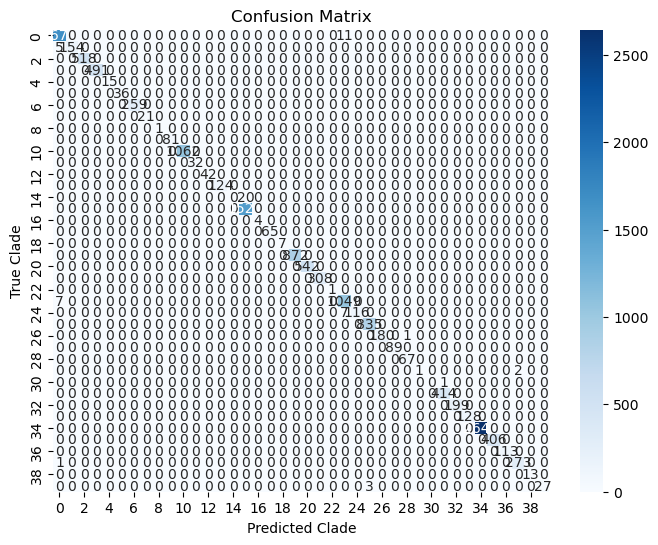

In [60]:
# # Confusion Matrix with Seaborn
# print("\nConfusion Matrix:")
# cm = confusion_matrix(y_true_new, y_pred_new)

# Confusion Matrix (on filtered data) - Open-Set Recognition version
print("\nConfusion Matrix (excluding 'Unseen Clade'):")
cm = confusion_matrix(y_true_new_filtered, y_pred_new_filtered)

# Create a new figure for the confusion matrix
plt.figure(figsize=(8, 6))

# Create heatmap using seaborn
heatmap(cm, annot=True, fmt="d", cmap="Blues") # Customize heatmap with annotations, format, and colormap

# Add labels and title
plt.xlabel("Predicted Clade")
plt.ylabel("True Clade")
plt.title("Confusion Matrix")

# Show the confusion matrix
plt.show()

End the timer

In [61]:
# End timing
end_time = time.time()

In [62]:
# Calculate and print total testing runtime
testing_time = end_time - start_time
print(f"\nTotal testing runtime: {format_runtime(testing_time)}")


Total testing runtime: 3 minutes and 14.00 seconds


#### What are the predicted clades for each subtype? 

In [63]:
# Create a new column 'Subtype' by concatenating 'H_Subtype' and 'N_Subtype'
test_df['Subtype'] = test_df['H_Subtype'] + test_df['N_Subtype']

In [64]:
# Group by 'Subtype' and collect 'Predicted_Clade' values
grouped_data = test_df.groupby(['Subtype', 'Predicted_Clade']).size().reset_index(name='Count')

# Calculate total count for the entire test dataset
total_count = len(test_df) 

# Calculate percentage using the total count of the test dataset
grouped_data['Percentage'] = ((grouped_data['Count'] / total_count) * 100).round(1)

# Rename the 'Predicted_Clade' column to 'Predicted Clades'
grouped_data = grouped_data.rename(columns={'Predicted_Clade': 'Predicted Clades'})
grouped_data

# Display the grouped_data directly in markdown format
print(grouped_data.to_markdown(index=False, numalign="left", stralign="left"))

,Subtype,Predicted Clades,Count,Percentage
0,H1N1,3C.2,3,0.0
1,H1N1,3C.3a,1,0.0
2,H1N1,6B.1,836,5.6
3,H1N1,6B.1A,180,1.2
4,H1N1,6B.1A.1,89,0.6
5,H1N1,6B.1A.2,68,0.5
6,H1N1,6B.1A.3,1,0.0
7,H1N1,6B.1A.5a,415,2.8
8,H1N1,6B.1A.5a.1,199,1.3
9,H1N1,6B.1A.5a.2,128,0.9


| Subtype   | Predicted Clades   | Count   | Percentage   |
|:----------|:-------------------|:--------|:-------------|
| H1N1      | 3C.2               | 3       | 0            |
| H1N1      | 3C.3a              | 1       | 0            |
| H1N1      | 6B.1               | 836     | 5.6          |
| H1N1      | 6B.1A              | 180     | 1.2          |
| H1N1      | 6B.1A.1            | 89      | 0.6          |
| H1N1      | 6B.1A.2            | 68      | 0.5          |
| H1N1      | 6B.1A.3            | 1       | 0            |
| H1N1      | 6B.1A.5a           | 415     | 2.8          |
| H1N1      | 6B.1A.5a.1         | 199     | 1.3          |
| H1N1      | 6B.1A.5a.2         | 128     | 0.9          |
| H1N1      | 6B.1A.5a.2a        | 2643    | 17.6         |
| H1N1      | 6B.1A.5a.2a.1      | 406     | 2.7          |
| H1N1      | 6B.1A.5b           | 113     | 0.8          |
| H1N1      | 6B.1A.6            | 275     | 1.8          |
| H1N1      | 6B.1A.7            | 13   